Привет, меня зовут Артем Вазлев. 

Представьте, что к вам обратился ваш коллега Богдан – менеджер по закупке рекламного трафика, с просьбой проанализировать окупаемость рекламных кампаний, привлекавших пользователей в январе 2021 года с одного из каналов. Он планирует запуск новых рекламных кампаний на те же регионы и необходимо определить некоторые ключевые показатели, опираясь на которые он смог бы понимать, успешны ли новые кампании. Он просит вас:
1)	Определить оптимальный срок оценки окупаемости рекламных кампаний.
2)	Определить наиболее успешные:
●	Рекламные кампании,
●	Тип рекламных кампаний,
●	Рекламную сеть
на момент оценки окупаемости.
3)	Рассчитать накопительный ARPU (average revenue per user) успешных рекламных кампаний, оптимизированных под покупки, на 7, 14, 30 день жизни аккаунтов, для прогноза окупаемости новых рекламных кампаний.
4)	Рассчитать фактический CPI (cost per install) для каждой рекламной кампании.
Вы уже выгрузили из базы необходимые файлы в формате .csv самостоятельно, а ваш коллега передал вам свой отчет о рекламном бюджете за январь 2021 года в формате .xls.
й на ранних стадиях (не дожидаясь достижения срока окупаемости), можете их описать с обоснованием и предоставить расчет - будет большим плюсом.

1)	«registrations.csv» – регистрации аккаунтов за январь 2021 год с одного из каналов. Описание данных:
account_id – ID аккаунта;
created_date – дата создания аккаунта;
campaign – рекламная кампания, с которой пришел пользователь
2)	«payments.csv» – платежи пользователей одного из каналов за 2021 год. Описание данных:
payment_date – дата оплаты
payment_types – типы платежных систем;
real_cost – сконвертированная сумма платежа;
account_id - ID аккаунта.
3)	«persents.csv» – комиссии платежных систем. Описание данных:
payment_types – типы платежных систем;
Share, %  - комиссия платежной системы.
4)	«Рекламный бюджет январь 2021.xlsx» - бюджет на рекламу в январе 2021 года. Описание данных:
media_source – рекламная сеть;
Campaign_type – тип рекламной кампании;
Target – регион, на который направлена рекламная кампания;
Plan, USD – планируемый бюджет;
Installs – фактическое количество установок;
Spend, USD – фактически потраченный бюджет;
Deviation, USD – отклонение от плана.

Comment:
our_fb (компания) подразумевается с 0 Spend, USD, тк это бесплатный приход с нашей группы Facebook.
None (компания) подразумевается с 0 Spend, USD, тк это органический приход.

Были выполнены действия, которые в некоторых ситуациях не учитывали их для подсчета результатов.
Таблица бюджетов редактирована для удобства и с учетом полученных данных из csv файлов (исправление некорректных данных коллеги, который выгрузил excel).

In [942]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.colors as matcol

In [945]:
budget = pd.read_excel("C:\\Users\\1\\проект 3\\Рекламный бюджет январь 2021.xlsx")
registrations = pd.read_csv("C:\\Users\\1\\проект 3\\registrations.csv", index_col='reg_id')
payments = pd.read_csv("C:\\Users\\1\\проект 3\\payments.csv")
commissions = pd.read_csv("C:\\Users\\1\\проект 3\\persents (1).csv", index_col='per_id')
budget_2 = pd.read_excel("C:\\Users\\1\\проект 3\\budget_2.xlsx")

In [947]:
print(budget.head())
print(commissions.head())
print(registrations.head())
print(payments.head())
print(budget_2)

           campaign  Plan, USD  Installs  Spend, USD  Deviation, USD
0   BRA_MS1_install        100     11462       99.12            0.88
1  BRA_MS1_purchase        400      1139      398.67            1.33
2   RUS_MS1_install        200     12649      246.30          -46.30
3  RUS_MS1_purchase        500      1581      616.77         -116.77
4   UKR_MS1_install        100      6790       99.43            0.57
           Payment_types  Share_%
per_id                           
0       Payment_system_1     20.7
1       Payment_system_2     15.0
2       Payment_system_3     58.5
3       Payment_system_4      0.0
4       Payment_system_5     24.0
        account_id created_date         campaign
reg_id                                          
0        3842380.0   2021-01-01  BRA_MS1_install
1        3842381.0   2021-01-01              NaN
2        3842382.0   2021-01-01              NaN
3        3842383.0   2021-01-01              NaN
4        3842384.0   2021-01-01  BRA_MS1_install
     

In [949]:
registrations = registrations.dropna(subset=['account_id'])
registrations['campaign'] = registrations['campaign'].fillna('no_company')
registrations['account_id'] = registrations['account_id'].astype(int)

In [951]:
payments = payments.drop_duplicates()

In [953]:
registrations['account_id'] = registrations['account_id'].astype('Int64')
registrations['created_date'] = pd.to_datetime(registrations['created_date'], errors='coerce')
registrations['campaign'] = registrations['campaign'].astype('str') 

payments['account_id'] = payments['account_id'].astype('Int64') 
payments['payment_date'] = pd.to_datetime(payments['payment_date'], errors='coerce')
payments['Payment_types'] = payments['Payment_types'].astype('str')
payments['real_cost'] = payments['real_cost'].astype('float64')

commissions['Payment_types'] = commissions['Payment_types'].astype('str')
commissions['Share_%'] = commissions['Share_%'].astype('float64')

budget['Plan, USD'] = budget['Plan, USD'].astype('float64')
budget['Spend, USD'] = budget['Spend, USD'].astype('float64')
budget['Deviation, USD'] = budget['Deviation, USD'].astype('float64')
budget['campaign'] = budget['campaign'].astype('str')

In [955]:
campaigns_of_interest = [
    'BRA_MS1_install',
    'BRA_MS1_purchase',
    'RUS_MS1_install',
    'RUS_MS1_purchase',
    'UKR_MS1_install',
    'UKR_MS1_purchase',
    'BRA_MS2_install',
    'ENG_MS2_install',
    'PR_youtube_bloger',
    'our_fb',
    'no_company'
]
filtered_registrations_df = registrations[registrations['campaign'].isin(campaigns_of_interest)]
registrations_count = filtered_registrations_df.groupby('campaign')['account_id'].nunique()
print("Количество регистраций для каждой кампании:")
print(registrations_count)

Количество регистраций для каждой кампании:
campaign
BRA_MS1_install      11462
BRA_MS1_purchase      1139
BRA_MS2_install        152
ENG_MS2_install        407
PR_youtube_bloger     1814
RUS_MS1_install      12649
RUS_MS1_purchase      1581
UKR_MS1_install       6790
UKR_MS1_purchase       260
no_company           52858
our_fb                  29
Name: account_id, dtype: int64


In [957]:
data = registrations.merge(payments, on='account_id', how='left')
data = data.merge(commissions, on='Payment_types')
filtered_data = data.loc[~data['campaign'].isin(['our_fb', 'no_company'])]
filtered_data = filtered_data.copy()


# Чистая выручка
filtered_data['net_revenue'] = filtered_data['real_cost'] * (1 - filtered_data['Share_%'] / 100)

# Кум выручка по дням для каждой кампании
cumulative_data = filtered_data.groupby(['campaign', 'payment_date'])['net_revenue'].sum().groupby(level=0).cumsum().reset_index()

cumulative_revenue = filtered_data.groupby(['campaign', 'payment_date'])['net_revenue'].sum().groupby(level=0).cumsum().reset_index(name='cumulative_net_revenue')

cumulative_revenue = cumulative_revenue.merge(budget, on='campaign', how='left')

# Точка окупаемости
def find_break_even_date(group):
    profitable_dates = group[group['cumulative_net_revenue'] >= group['Spend, USD'].iloc[0]]['payment_date']
    if not profitable_dates.empty:
        return profitable_dates.iloc[0]
    return pd.NaT

break_even_dates = cumulative_revenue.groupby('campaign').apply(
    find_break_even_date, include_groups=False
).reset_index(name='break_even_date')

registrations['created_date'] = pd.to_datetime(registrations['created_date'])
start_dates = registrations.groupby('campaign')['created_date'].min().reset_index()
start_dates.columns = ['campaign', 'start_date']

result = break_even_dates.merge(start_dates, on='campaign')

# Расчет срока окупаемости в днях
result['days_to_break_even'] = (result['break_even_date'] - result['start_date']).dt.days

df_cleaned = result[result['campaign'] != 'no_company']

print(df_cleaned)

            campaign     break_even_date start_date  days_to_break_even
0    BRA_MS1_install 2021-02-26 17:44:33 2021-01-01                56.0
1   BRA_MS1_purchase 2021-07-30 00:03:11 2021-01-01               210.0
2    BRA_MS2_install                 NaT 2021-01-05                 NaN
3    ENG_MS2_install                 NaT 2021-01-01                 NaN
4  PR_youtube_bloger                 NaT 2021-01-01                 NaN
5    RUS_MS1_install 2021-05-10 00:16:05 2021-01-01               129.0
6   RUS_MS1_purchase 2021-10-16 13:45:33 2021-01-01               288.0
7    UKR_MS1_install 2021-10-16 02:28:14 2021-01-01               288.0
8   UKR_MS1_purchase 2021-06-18 23:26:09 2021-01-01               168.0


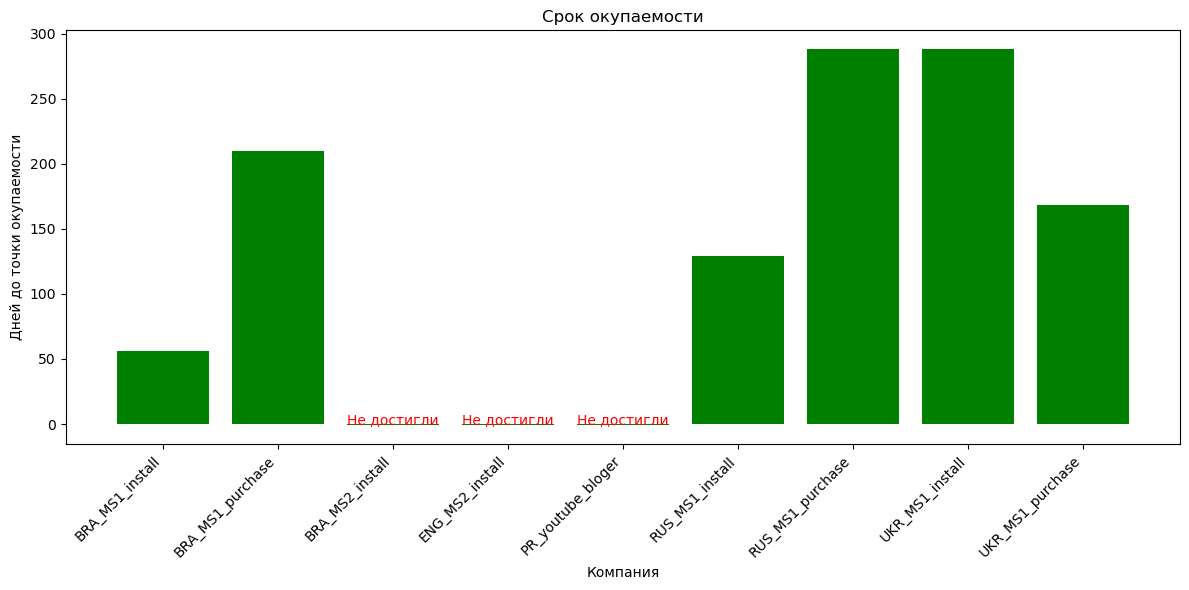

In [959]:
data_for_plotting = df_cleaned.copy()

special_value = -1  

data_for_plotting = data_for_plotting.assign(
    days_to_break_even=data_for_plotting['days_to_break_even'].fillna(special_value)
)
plt.figure(figsize=(12, 6))
plt.bar(data_for_plotting['campaign'], data_for_plotting['days_to_break_even'], color='green')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Компания')
plt.ylabel('Дней до точки окупаемости')
plt.title('Срок окупаемости')

for i, v in enumerate(data_for_plotting['days_to_break_even']):
    if v == special_value:
        plt.text(i, v + 1, 'Не достигли', color='red', ha='center')

plt.tight_layout()
plt.savefig('data_for_plotting.png')
plt.show()

задание 2

In [962]:
revenue_by_campaign = filtered_data.groupby('campaign')['net_revenue'].sum().reset_index()

campaign_data = budget.merge(revenue_by_campaign, on='campaign')

# Р ROI
campaign_data['ROI'] = ((campaign_data['net_revenue'] - campaign_data['Spend, USD']) / campaign_data['Spend, USD']) * 100

# Извлечение типов кампаний и сетей
campaign_data['campaign_type'] = campaign_data['campaign'].apply(
    lambda x: 'install' if 'install' in x else 'purchase')
campaign_data['network'] = campaign_data['campaign'].apply(
    lambda x: 'MS1' if 'MS1' in x else ('MS2' if 'MS2' in x else 'youtube'))

top_campaigns = campaign_data.sort_values(by='ROI', ascending=False)

roi_by_type = campaign_data.groupby('campaign_type')['ROI'].mean().reset_index().sort_values(by='ROI', ascending=False)
roi_by_network = campaign_data.groupby('network')['ROI'].mean().reset_index().sort_values(by='ROI', ascending=False)

print("Наиболее успешные рекламные кампании:")
print(top_campaigns[['campaign', 'ROI']])

print("\nНаиболее успешные типы рекламных кампаний:")
print(roi_by_type)

print("\nНаиболее успешные рекламные сети:")
print(roi_by_network)

Наиболее успешные рекламные кампании:
            campaign         ROI
2    RUS_MS1_install  212.826407
0    BRA_MS1_install  202.941442
5   UKR_MS1_purchase  191.287575
3   RUS_MS1_purchase   37.954723
1   BRA_MS1_purchase   17.519141
4    UKR_MS1_install    8.959930
8  PR_youtube_bloger  -46.342070
7    ENG_MS2_install  -74.360513
6    BRA_MS2_install  -81.263784

Наиболее успешные типы рекламных кампаний:
  campaign_type        ROI
0       install  53.820696
1      purchase  50.104842

Наиболее успешные рекламные сети:
   network         ROI
0      MS1  111.914870
2  youtube  -46.342070
1      MS2  -77.812149


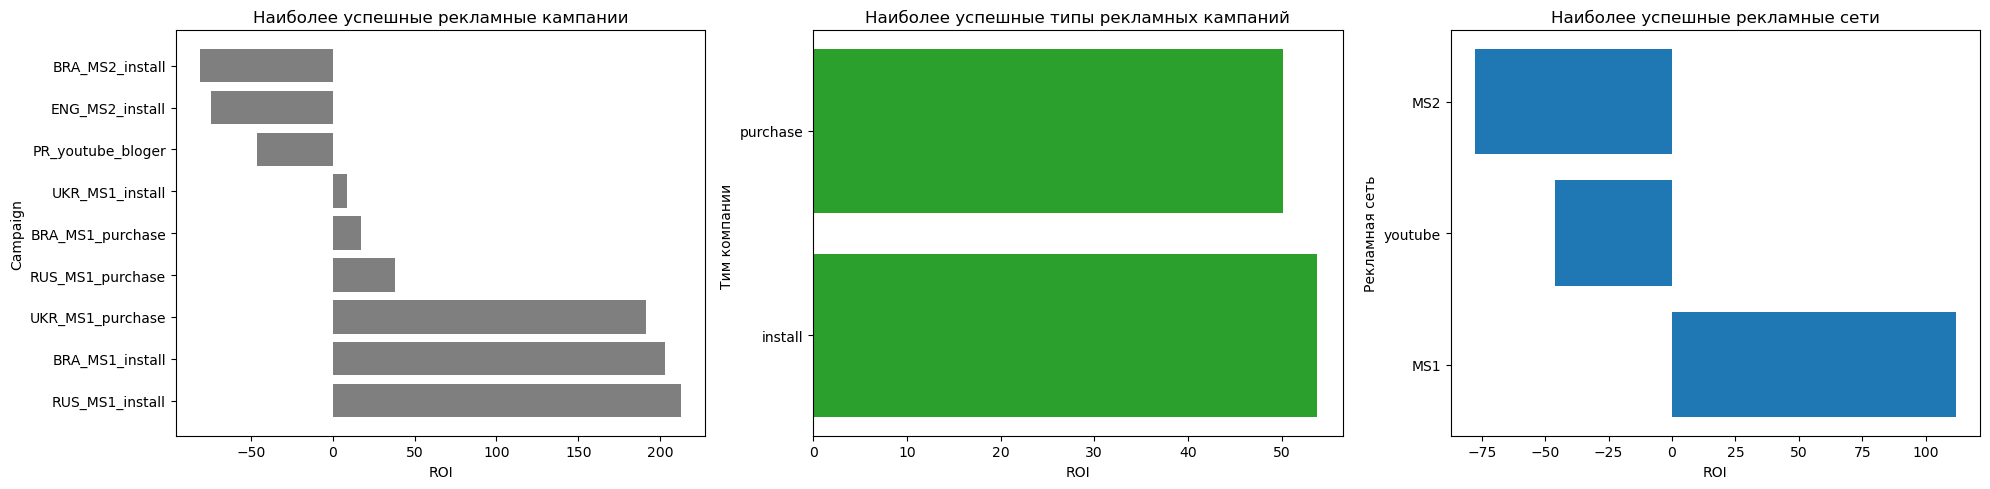

In [964]:
campaign_df = pd.DataFrame(top_campaigns)
campaign_types_df = pd.DataFrame(roi_by_type)
networks_df = pd.DataFrame(roi_by_network)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

# Наиб успешные рекламные кампании
axes[0].barh(campaign_df['campaign'], campaign_df['ROI'], color='tab:grey')
axes[0].set_title('Наиболее успешные рекламные кампании')
axes[0].set_xlabel('ROI')
axes[0].set_ylabel('Campaign')

# Наиб успешные типы рекламных кампаний
axes[1].barh(campaign_types_df['campaign_type'], campaign_types_df['ROI'], color='tab:green')
axes[1].set_title('Наиболее успешные типы рекламных кампаний')
axes[1].set_xlabel('ROI')
axes[1].set_ylabel('Тим компании ')

# Наиб успешные рекламные сети
axes[2].barh(networks_df['network'], networks_df['ROI'], color='tab:blue')
axes[2].set_title('Наиболее успешные рекламные сети')
axes[2].set_xlabel('ROI')
axes[2].set_ylabel('Рекламная сеть')

plt.tight_layout()
plt.savefig('data_for_plotting2.png')
plt.show()

задание 3

In [967]:
filtered_data['days_since_creation'] = (filtered_data['payment_date'] - filtered_data['created_date']).dt.days

data_cleaned = filtered_data[filtered_data['campaign'] != 'no_company']

# Фильтрация по необходимым дням
data_7_days = data_cleaned[data_cleaned['days_since_creation'] <= 7]
data_14_days = data_cleaned[data_cleaned['days_since_creation'] <= 14]
data_30_days = data_cleaned[data_cleaned['days_since_creation'] <= 30]

# ARPU
def calculate_arpu(df, days):
    revenue_per_campaign = df.groupby('campaign')['net_revenue'].sum()
    installs_per_campaign = budget.set_index('campaign')['Installs']
    arpu = (revenue_per_campaign / installs_per_campaign)
    return arpu

arpu_7_days = calculate_arpu(data_7_days, 7)
arpu_14_days = calculate_arpu(data_14_days, 14)
arpu_30_days = calculate_arpu(data_30_days, 30)


print("ARPU на 7 день:\n", arpu_7_days)
print("ARPU на 14 день:\n", arpu_14_days)
print("ARPU на 30 день:\n", arpu_30_days)

ARPU на 7 день:
 campaign
BRA_MS1_install      0.002469
BRA_MS1_purchase     0.153115
BRA_MS2_install      0.044359
ENG_MS2_install      0.032560
PR_youtube_bloger    0.028985
RUS_MS1_install      0.002831
RUS_MS1_purchase     0.055184
UKR_MS1_install      0.003895
UKR_MS1_purchase     0.180892
dtype: float64
ARPU на 14 день:
 campaign
BRA_MS1_install      0.002555
BRA_MS1_purchase     0.153115
BRA_MS2_install      0.044359
ENG_MS2_install      0.032928
PR_youtube_bloger    0.028985
RUS_MS1_install      0.003957
RUS_MS1_purchase     0.073474
UKR_MS1_install      0.003909
UKR_MS1_purchase     0.180892
dtype: float64
ARPU на 30 день:
 campaign
BRA_MS1_install      0.005492
BRA_MS1_purchase     0.153734
BRA_MS2_install      0.044359
ENG_MS2_install      0.032928
PR_youtube_bloger    0.029222
RUS_MS1_install      0.006652
RUS_MS1_purchase     0.127359
UKR_MS1_install      0.004318
UKR_MS1_purchase     0.511556
dtype: float64


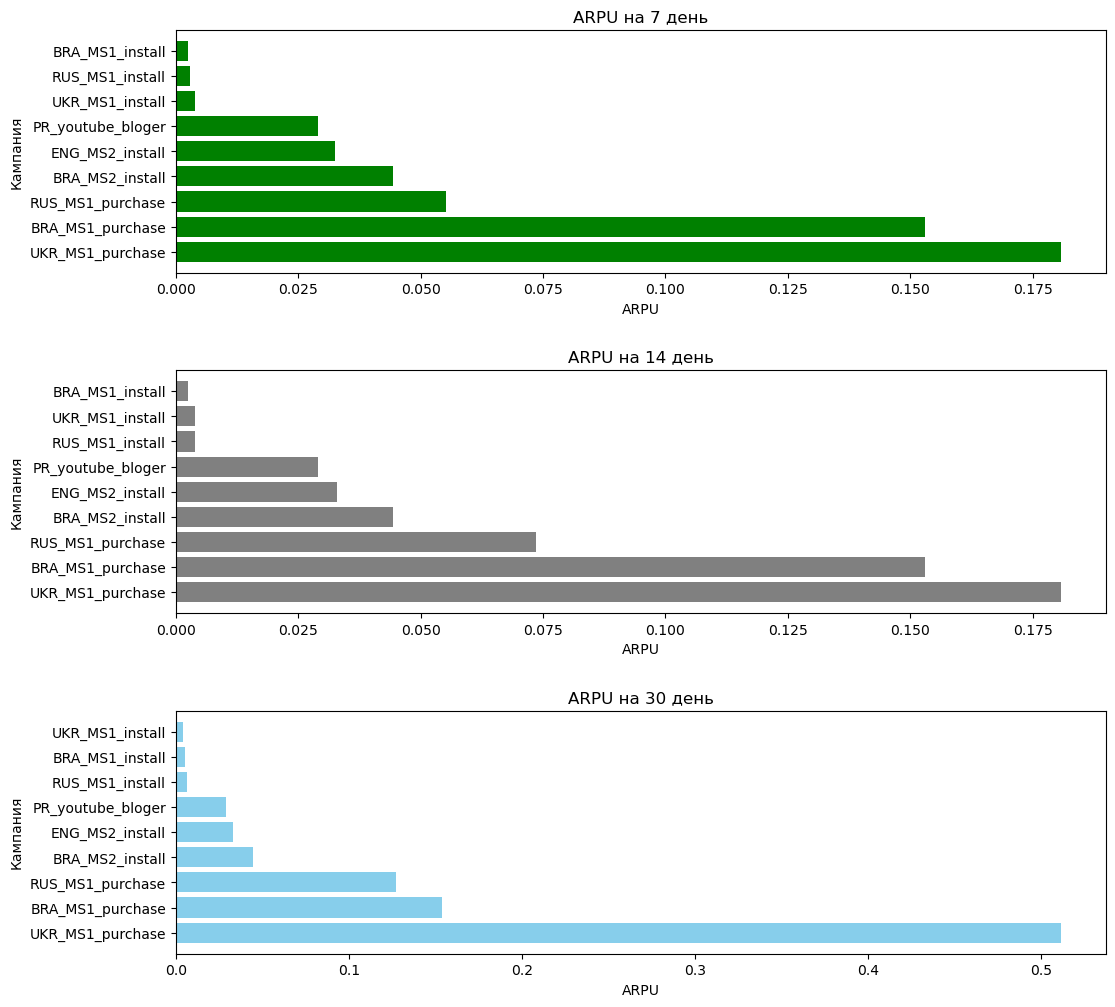

In [969]:
def sort_arpu(data):
    return sorted(data.items(), key=lambda x: x[1], reverse=True)

sorted_arpu_7_days = sort_arpu(arpu_7_days)
sorted_arpu_14_days = sort_arpu(arpu_14_days)
sorted_arpu_30_days = sort_arpu(arpu_30_days)

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))
fig.subplots_adjust(hspace=0.4)  # Добавить промежуток между субграфиками

# 7 days ARPU
campaigns, arpu_values = zip(*sorted_arpu_7_days)
axs[0].barh(campaigns, arpu_values, color='green')
axs[0].set_title('ARPU на 7 день')
axs[0].set_xlabel('ARPU')
axs[0].set_ylabel('Кампания')

# 14 days ARPU
campaigns, arpu_values = zip(*sorted_arpu_14_days)
axs[1].barh(campaigns, arpu_values, color='grey')
axs[1].set_title('ARPU на 14 день')
axs[1].set_xlabel('ARPU')
axs[1].set_ylabel('Кампания')

# 30 days ARPU
campaigns, arpu_values = zip(*sorted_arpu_30_days)
axs[2].barh(campaigns, arpu_values, color='skyblue')
axs[2].set_title('ARPU на 30 день')
axs[2].set_xlabel('ARPU')
axs[2].set_ylabel('Кампания')

plt.savefig('data_for_plotting3.png')
plt.show()

Задание 4

In [972]:
budget['CPI'] = budget['Spend, USD'] / budget['Installs']

budget_cleaned = budget.dropna(subset=['CPI']).replace([float('inf'), -float('inf')], float('nan')).dropna(subset=['CPI'])

print(budget_cleaned[['campaign', 'CPI']])

            campaign       CPI
0    BRA_MS1_install  0.008648
1   BRA_MS1_purchase  0.350018
2    RUS_MS1_install  0.019472
3   RUS_MS1_purchase  0.390114
4    UKR_MS1_install  0.014644
5   UKR_MS1_purchase  1.338962
6    BRA_MS2_install  0.533882
7    ENG_MS2_install  0.245577
8  PR_youtube_bloger  0.054727


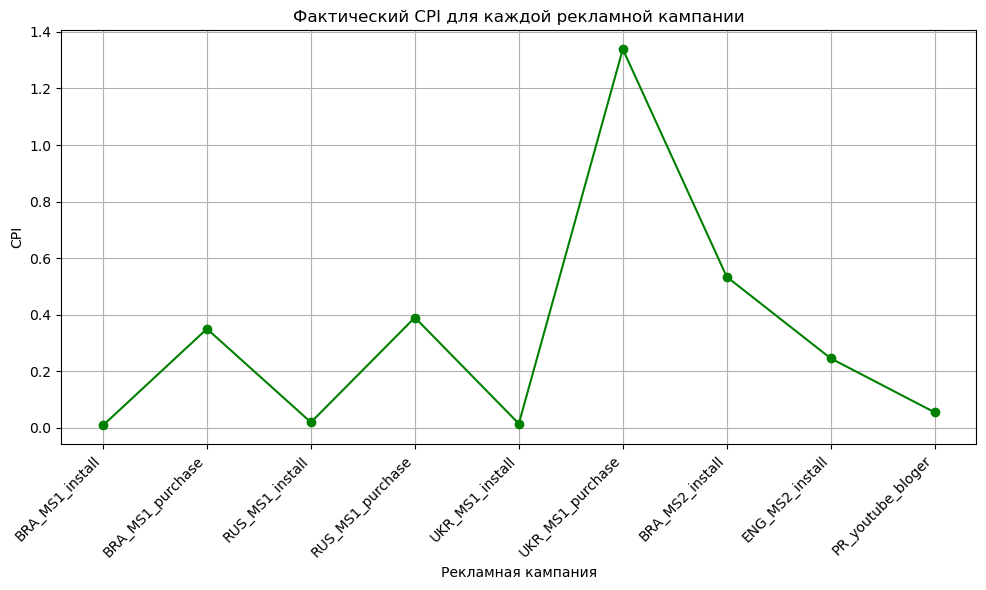

In [974]:
campaigns = budget_cleaned['campaign'].tolist()
cpi_values = budget_cleaned['CPI'].tolist()

plt.figure(figsize=(10, 6))
plt.plot(campaigns, cpi_values, marker='o', linestyle='-', color='green')

plt.title('Фактический CPI для каждой рекламной кампании')
plt.xlabel('Рекламная кампания')
plt.ylabel('CPI')
plt.xticks(rotation=45, ha='right')
plt.grid(True)

plt.tight_layout()
plt.savefig('data_for_plotting4.png')
plt.show()

In [976]:
#доп метрики

In [978]:
cpa_without_organice_and_fb = budget['Spend, USD'].sum() / budget['Installs'].sum()
ltv_without_organice_and_fb = filtered_data['net_revenue'].sum() / filtered_data['account_id'].nunique()
roi_without_organice_and_fb = ((filtered_data['net_revenue'].sum() - budget['Spend, USD'].sum()) / budget['Spend, USD'].sum()) * 100

print(f"CPA: {cpa:.2f} USD")
print(f"Средний LTV: {ltv:.2f} USD")
print(f"ROI: {roi:.2f}%")

CPA: 0.06 USD
Средний LTV: 17.09 USD
ROI: 72.67%
